Kolmogorov-Arnold Network는 Kolmogorov-Arnold representation theorem에서 기초한 것으로, `연속적인 다변량 함수를 일변수 함수의 합성으로 표한할 수 있음`을 전제함

이를 수식으로 표현하면 아래와 같음

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Math
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
# 콜모고로프-아르놀드 정리 수식 표시
equation = r"""
\displaystyle f(x_1, x_2, \dots, x_n) = \sum_{q=1}^{2n+1} \phi_q\left( \sum_{p=1}^n \psi_p(x_p) + c_q \right)
"""
display(Math(equation))

<IPython.core.display.Math object>

In [3]:
# 근사하려는 실제 함수 수식 표시
equation = r"""
\displaystyle f(x_1, x_2) = \sin(x_1 + x_2)
"""
display(Math(equation))

<IPython.core.display.Math object>

In [4]:
# 입력 데이터 생성
x1 = np.linspace(-2*np.pi, 2*np.pi, 200)
x2 = np.linspace(-2*np.pi, 2*np.pi, 200)
X1, X2 = np.meshgrid(x1, x2)

# 입력 데이터를 벡터 형태로 변환
X_input = np.stack([X1.flatten(), X2.flatten()], axis=1)

# 실제 함수 값 계산
def f_true(x):
    return np.sin(x[:, 0] + x[:, 1])

Y_true = f_true(X_input)
Y_true.shape

(40000,)

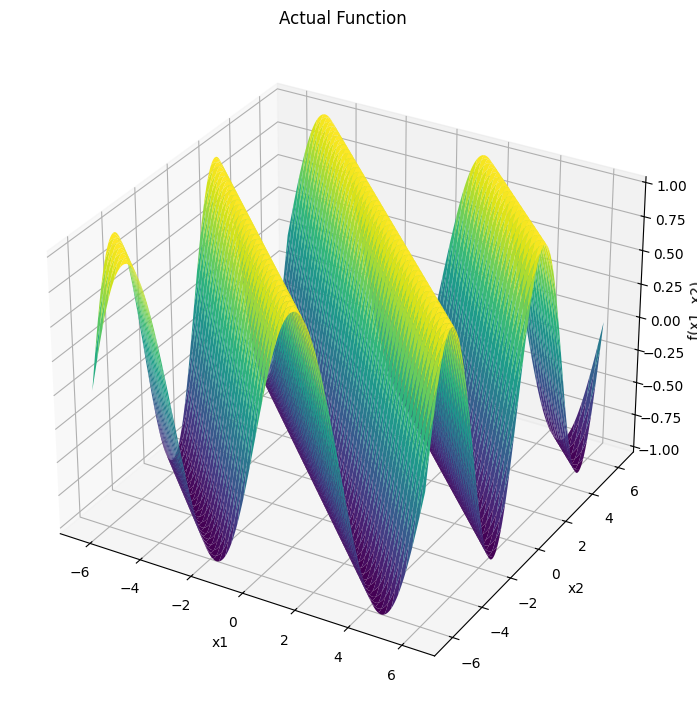

In [5]:
# Y_true 시각화
def plot_approximations_torch(X1, X2, Y_true):
    fig = plt.figure(figsize=(18, 14))

    # 실제 함수 시각화
    ax = fig.add_subplot(2, 1, 1, projection='3d')
    ax.plot_surface(X1, X2, Y_true.reshape(X1.shape), cmap='viridis')
    ax.set_title('Actual Function')
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('f(x1, x2)')

    plt.tight_layout()
    plt.show()

plot_approximations_torch(X1, X2, Y_true)

In [6]:
# 데이터를 PyTorch 텐서로 변환
X_tensor = torch.tensor(X_input, dtype=torch.float32)
Y_tensor = torch.tensor(Y_true.reshape(-1, 1), dtype=torch.float32)

In [7]:
# 간단한 함수 집합 모델 정의
class SimpleFuncs(nn.Module):
    def __init__(self, n_input):
        super(SimpleFuncs, self).__init__()
        hidden_dim1 = 32
        hidden_dim2 = 8
        self.fc1 = nn.Linear(n_input, hidden_dim1)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_dim2, 1)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        
        return x

model = SimpleFuncs(n_input=2)
print(model)

SimpleFuncs(
  (fc1): Linear(in_features=2, out_features=32, bias=True)
  (act1): ReLU()
  (fc2): Linear(in_features=32, out_features=8, bias=True)
  (act2): ReLU()
  (fc3): Linear(in_features=8, out_features=1, bias=True)
)


In [9]:
from torchsummary import summary

summary(model, input_size=(2,), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]              96
              ReLU-2                   [-1, 32]               0
            Linear-3                    [-1, 8]             264
              ReLU-4                    [-1, 8]               0
            Linear-5                    [-1, 1]               9
Total params: 369
Trainable params: 369
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [10]:
# 손실 함수와 옵티마이저 정의
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 에포크별로 결과를 저장하기 위한 리스트
epochs_to_save = [199, 399, 599, 799, 999]
outputs = []
loss_history = []
num_epochs = 1000

In [11]:
# 모델 학습
for epoch in range(num_epochs):
    model.train()
    
    # 순전파
    outputs_pred = model(X_tensor)
    loss = criterion(outputs_pred, Y_tensor)
    
    # 역전파 및 최적화
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # 손실 저장
    loss_history.append(loss.item())
    
    # 에포크별 결과 저장
    if epoch in epochs_to_save:
        with torch.no_grad():
            model.eval()
            Y_pred = model(X_tensor).detach().numpy()
            outputs.append((epoch, Y_pred))
    
    # 진행 상황 출력
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')

Epoch [10/1000], Loss: 0.505210
Epoch [20/1000], Loss: 0.493536
Epoch [30/1000], Loss: 0.488241
Epoch [40/1000], Loss: 0.483842
Epoch [50/1000], Loss: 0.479537
Epoch [60/1000], Loss: 0.475062
Epoch [70/1000], Loss: 0.470277
Epoch [80/1000], Loss: 0.465116
Epoch [90/1000], Loss: 0.459529
Epoch [100/1000], Loss: 0.453664
Epoch [110/1000], Loss: 0.447461
Epoch [120/1000], Loss: 0.440912
Epoch [130/1000], Loss: 0.433972
Epoch [140/1000], Loss: 0.426652
Epoch [150/1000], Loss: 0.418964
Epoch [160/1000], Loss: 0.410835
Epoch [170/1000], Loss: 0.400296
Epoch [180/1000], Loss: 0.390892
Epoch [190/1000], Loss: 0.381215
Epoch [200/1000], Loss: 0.371507
Epoch [210/1000], Loss: 0.361825
Epoch [220/1000], Loss: 0.352153
Epoch [230/1000], Loss: 0.342465
Epoch [240/1000], Loss: 0.332706
Epoch [250/1000], Loss: 0.322726
Epoch [260/1000], Loss: 0.312080
Epoch [270/1000], Loss: 0.300267
Epoch [280/1000], Loss: 0.288891
Epoch [290/1000], Loss: 0.278099
Epoch [300/1000], Loss: 0.267487
Epoch [310/1000], L

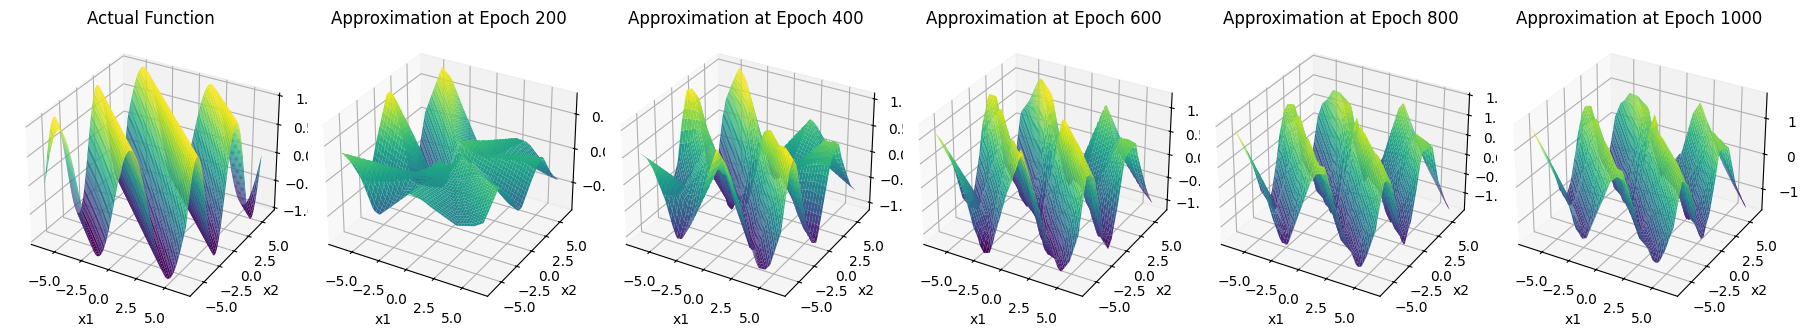

In [12]:
# 에포크별 결과 시각화 함수 정의
def plot_approximations_torch(X1, X2, Y_true, outputs):
    fig = plt.figure(figsize=(18, 12))

    # 실제 함수 시각화
    ax = fig.add_subplot(1, 6, 1, projection='3d')
    ax.plot_surface(X1, X2, Y_true.reshape(X1.shape), cmap='viridis')
    ax.set_title('Actual Function')
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('f(x1, x2)')

    # 에포크별 근사 결과 시각화
    for i, (epoch, Y_pred) in enumerate(outputs):
        ax = fig.add_subplot(1, 6, i+2, projection='3d')
        ax.plot_surface(X1, X2, Y_pred.reshape(X1.shape), cmap='viridis')
        ax.set_title(f'Approximation at Epoch {epoch+1}')
        ax.set_xlabel('x1')
        ax.set_ylabel('x2')
        ax.set_zlabel('Approximation')

    plt.tight_layout()
    plt.show()

plot_approximations_torch(X1, X2, Y_true, outputs)


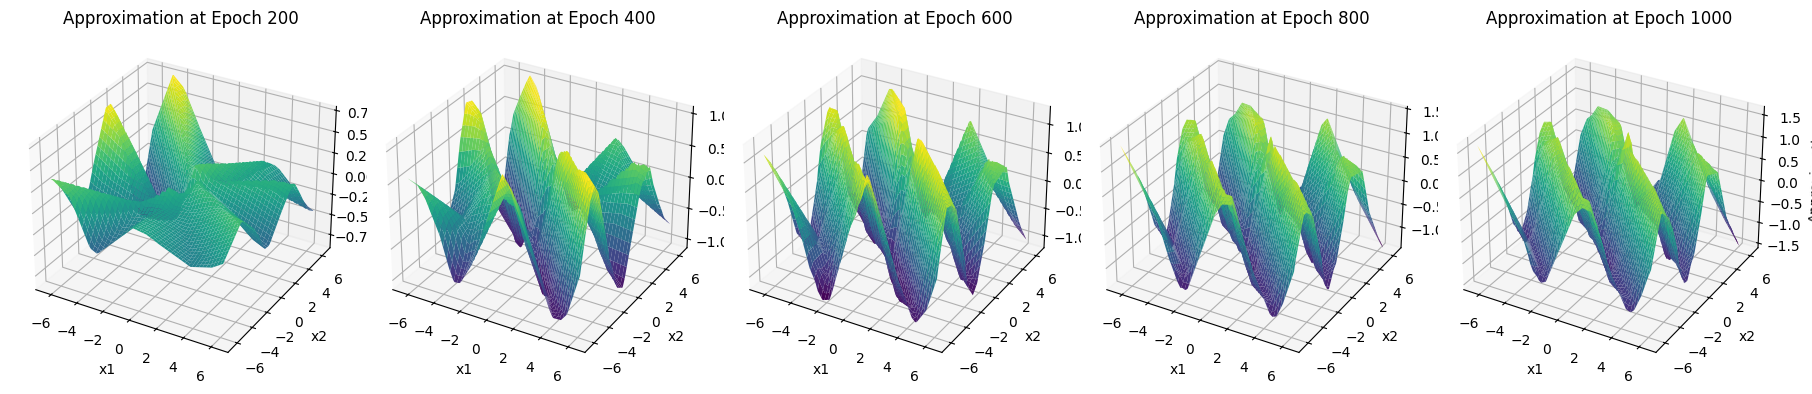

In [13]:
# 에포크별 결과 시각화 함수 정의
def plot_approximations_torch(X1, X2, Y_true, outputs):
    fig = plt.figure(figsize=(18, 12))

    # 에포크별 근사 결과 시각화
    for i, (epoch, Y_pred) in enumerate(outputs):
        ax = fig.add_subplot(1, 5, i+1, projection='3d')
        ax.plot_surface(X1, X2, Y_pred.reshape(X1.shape), cmap='viridis')
        ax.set_title(f'Approximation at Epoch {epoch+1}')
        ax.set_xlabel('x1')
        ax.set_ylabel('x2')
        ax.set_zlabel('Approximation')

    plt.tight_layout()
    plt.show()

plot_approximations_torch(X1, X2, Y_true, outputs)
